In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Hyper Parameters
BATCH_SIZE = 100
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas

In [3]:
PAINT_POINTS = []
for _ in range(0 , BATCH_SIZE):
    PAINT_POINTS.append(np.linspace(-1 , 1 , ART_COMPONENTS))
PAINT_POINTS = np.array(PAINT_POINTS)   

def artist_works():    
    a = np.random.uniform(1 , 2 , size = BATCH_SIZE)
    paintings = []
    for i in range(0 , BATCH_SIZE):
        paintings.append(a[i] * PAINT_POINTS[i , :] ** 2 + a[i] - 1)
    paintings = np.array(paintings)
    return paintings

In [4]:
def add_layer(inputs , in_size , out_size , activaction_function = None): 
    Weights = tf.get_variable(initializer = tf.truncated_normal([in_size , out_size] , mean = 0.001 , stddev = 0.3) , name = 'w_a')
    biases = tf.get_variable(initializer = tf.zeros([1 , out_size]) + 0.001 , name = 'b_a')
    Wx_plus_b = tf.add(tf.matmul(inputs , Weights) , biases) 

    # here to activaction_function
    if activaction_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activaction_function(Wx_plus_b , name = 'output')
        
    return outputs 

In [5]:
# define placeholder for inputs to network
xs_G = tf.placeholder(tf.float32 , [None , N_IDEAS])
xs_D = tf.placeholder(tf.float32 , [None , ART_COMPONENTS])

In [6]:
# Generator，相當於偽造家
with tf.variable_scope('Generator'):
    with tf.variable_scope('hidden_layer'):
        layer_G = add_layer(xs_G , N_IDEAS , 128 , activaction_function = tf.nn.relu)
    with tf.variable_scope('output_layer'):
        G_out = add_layer(layer_G , 128 , ART_COMPONENTS , activaction_function = None)   

# Discriminator，相當於鑑定師
with tf.variable_scope('Discriminator'):
    with tf.variable_scope('hidden_layer'): 
        layer_D_for_G = add_layer(G_out , ART_COMPONENTS , 128 , activaction_function = tf.nn.relu)
        tf.get_variable_scope().reuse_variables() 
        layer_D_for_D = add_layer(xs_D , ART_COMPONENTS , 128 , activaction_function = tf.nn.relu)       

    with tf.variable_scope('output_layer'):
        # 以鑑定師D的角度來看，會希望將偽造品鑑定為真品的機率越小越好，也就是希望prob_artist_for_G越小越好
        # 但是以偽造家G的角度來看，會希望將偽造品鑑定為真品的機率越大越好，也就是希望prob_artist_for_D越大越好
        prob_artist_for_G = add_layer(layer_D_for_G , 128 , 1 , activaction_function = tf.nn.sigmoid)
        tf.get_variable_scope().reuse_variables()

        # 以鑑定師D的角度來看，會希望原來就是真品鑑定為真品的機率越大越好，也就是希望prob_artist_for_D越大越好
        prob_artist_for_D = add_layer(layer_D_for_D , 128 , 1 , activaction_function = tf.nn.sigmoid)

In [7]:
# 偽造家G會希望prob_artist_for_D越大越好，等同於(1. - prob_artist_for_G)越小越好
# 所以G_loss確實會越來越小
G_loss = tf.reduce_mean(tf.log(1 - prob_artist_for_G) , 0)[0]  

# 鑑定師D會希望prob_artist_for_G越小越好，等同於 -(1. - prob_artist_for_G) 越小越好
# 鑑定師D也會希望prob_artist_for_D越大越好，等同於 -prob_artist_for_D 越小越好
# 所以D_loss會越來越小
D_loss = -tf.reduce_mean(tf.log(1. - prob_artist_for_G) + tf.log(prob_artist_for_D) , 0)[0] 

In [8]:
# 這個步驟很重要!!
# 訓練Generator與Discriminator時，兩者的參數分開來訓練會比較容易訓練
# 訓練Generator時，凍結Discriminator的參數
# 訓練Discriminator時，凍結Generator的參數
variable_Generator , variable_Discriminator = [] , []
for i in tf.trainable_variables(): 
    if 'Generator' in i.name : variable_Generator.append(i)
    if 'Discriminator' in i.name : variable_Discriminator.append(i)
train_Generator = tf.train.AdamOptimizer(LR_G).minimize(G_loss , var_list = variable_Generator)
train_Discriminator = tf.train.AdamOptimizer(LR_D).minimize(D_loss , var_list = variable_Discriminator)
train_op = tf.group([train_Generator , train_Discriminator])

In [9]:
sess = tf.Session() 
sess.run(tf.global_variables_initializer())

G_paintings_list = []
for step in range(0 , 5000):
    artist_paintings = artist_works()
    G_ideas = np.random.rand(BATCH_SIZE , N_IDEAS)
    _ , G_loss_ , D_loss_ =  sess.run([train_op , G_loss , D_loss] , feed_dict = {xs_G : G_ideas , xs_D : artist_paintings})
    
    if step % 100 == 0:
        print('=' * 30)
        print('step : {}'.format(step))
        print('G_loss : {:.2f} , D_loss : {:.2f}'.format(G_loss_ , D_loss_))
    
    if step % 250 == 0:
        G_paintings = sess.run(G_out , feed_dict = {xs_G : G_ideas})
        G_paintings_list.append(G_paintings[0 , :])

step : 0
G_loss : -0.45 , D_loss : 1.27
step : 100
G_loss : -1.01 , D_loss : 1.28
step : 200
G_loss : -1.16 , D_loss : 1.41
step : 300
G_loss : -0.89 , D_loss : 1.15
step : 400
G_loss : -0.50 , D_loss : 0.72
step : 500
G_loss : -0.47 , D_loss : 0.68
step : 600
G_loss : -0.39 , D_loss : 0.60
step : 700
G_loss : -0.37 , D_loss : 0.62
step : 800
G_loss : -0.61 , D_loss : 1.02
step : 900
G_loss : -0.72 , D_loss : 1.31
step : 1000
G_loss : -0.57 , D_loss : 1.12
step : 1100
G_loss : -0.52 , D_loss : 1.06
step : 1200
G_loss : -0.57 , D_loss : 1.26
step : 1300
G_loss : -0.57 , D_loss : 1.30
step : 1400
G_loss : -0.54 , D_loss : 1.29
step : 1500
G_loss : -0.54 , D_loss : 1.32
step : 1600
G_loss : -0.53 , D_loss : 1.31
step : 1700
G_loss : -0.52 , D_loss : 1.29
step : 1800
G_loss : -0.53 , D_loss : 1.28
step : 1900
G_loss : -0.53 , D_loss : 1.27
step : 2000
G_loss : -0.56 , D_loss : 1.27
step : 2100
G_loss : -0.59 , D_loss : 1.27
step : 2200
G_loss : -0.60 , D_loss : 1.28
step : 2300
G_loss : -0

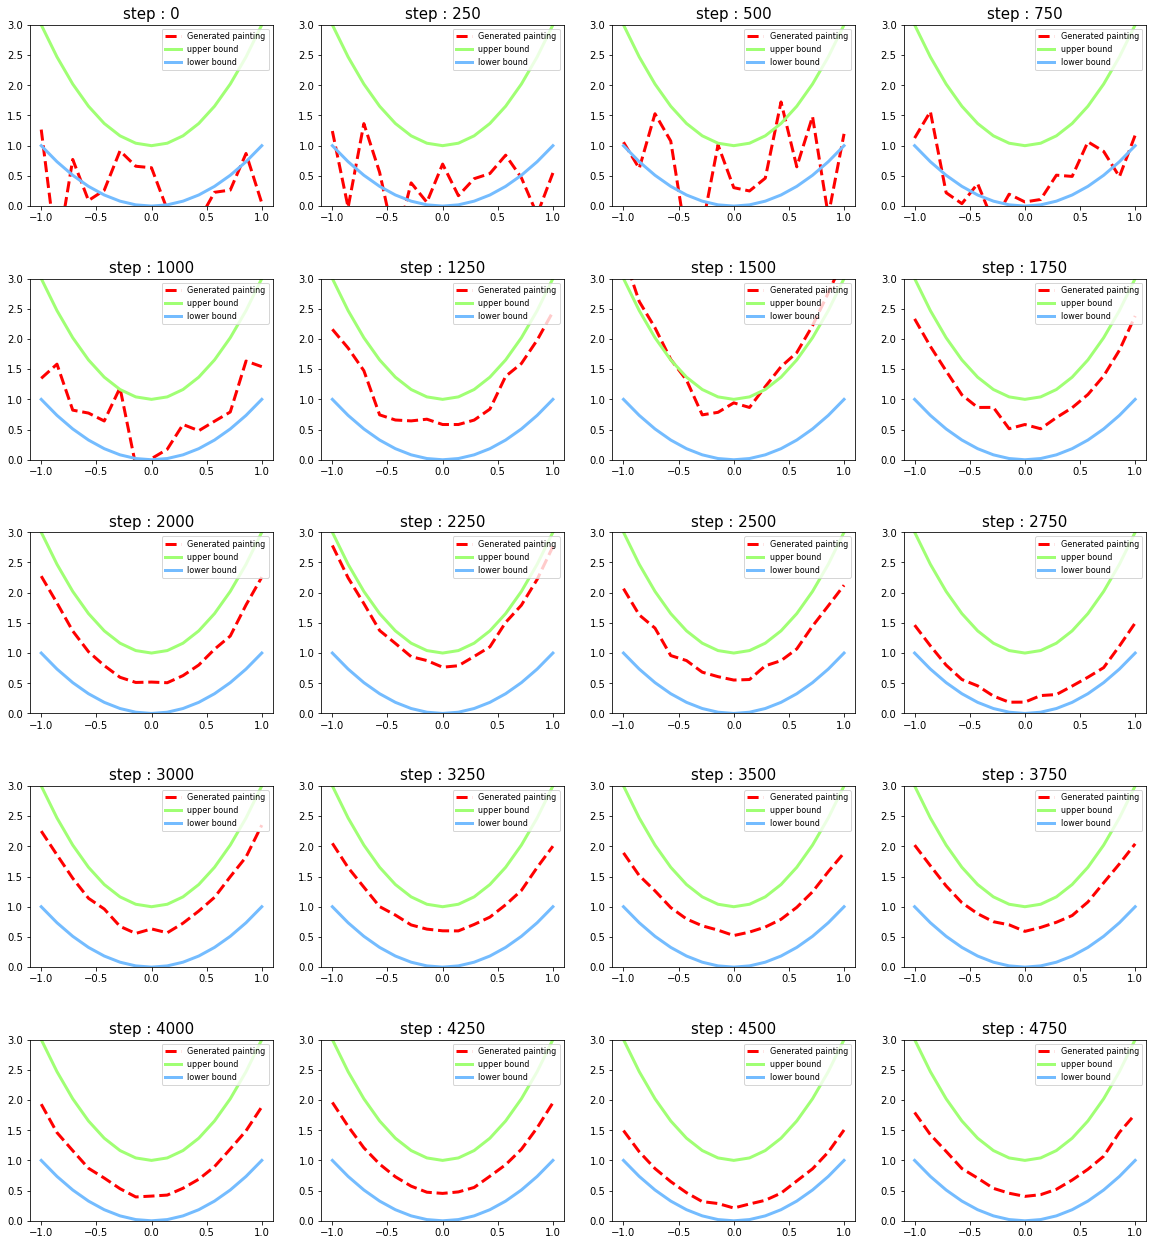

In [10]:
fig , ax = plt.subplots(5 , 4 , figsize = (20 , 22))
plt.subplots_adjust(wspace = 0.2 , hspace = 0.4)

for i in range(0 , 5):
    for j in range(0 , 4):
        G_paintings = G_paintings_list[4 * i + j]
        ax[i , j].plot(PAINT_POINTS[0 , :] , G_paintings, c = 'r' , lw = 3 , ls = '--' , label = 'Generated painting')
        ax[i , j].plot(PAINT_POINTS[0 , :] , 2 * np.power(PAINT_POINTS[0 , :] , 2) + 1 , c = '#a0ff74' , lw = 3 , label = 'upper bound')
        ax[i , j].plot(PAINT_POINTS[0 , :] , 1 * np.power(PAINT_POINTS[0 , :] , 2) + 0 , c = '#74BCFF' , lw = 3 , label = 'lower bound')
        ax[i , j].set_title('step : {:1d}'.format((4 * i + j) * 250) , fontsize = 15) 
        ax[i , j].set_ylim((0 , 3))
        ax[i , j].legend(loc = 'upper right' , fontsize = 8)